In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('../Data/cleaned/all_season_results.csv')
data.head()

,id,name,original_season_id,real_name,dob,gender,hometown,location,type,miss_con,final_place,safe,win,high,btm
0,Q100,Akashia,F10S01,Eric Flint,"February 19, 1985",NaN,NaN,"Cleveland, OH, USA",Pageant,NaN,7,0,0,0,2
1,Q101,BeBe Zahara Benet,F10S01,Nea Marshall Kudi Ngwa,"March 20, 1981",Male,"Yaoundé, Cameroon","Minneapolis, MN, USA",Pageant,NaN,1,2,3,1,1
2,Q102,Jade,F10S01,David Sotomayor,"November 18, 1984",NaN,"Chicago, IL, USA",NaN,Comedy,NaN,6,2,0,0,0
3,Q103,Nina Flowers,F10S01,Jorge Luis Flores Sánchez,"February 22, 1974",Male,"Denver, CO, USA","Dallas, TX, USA",Club,1.0,2,1,1,4,0
4,Q104,Ongina,F10S01,Ryan Ong Palao,"January 6, 1982",NaN,"Seattle, WA, USA","Los Angeles, CA, USA",Look,NaN,5,0,2,2,0


In [2]:
data['miss_con'].fillna(0,inplace=True)

In [4]:
b_year = [str(x).split(",")[-1].replace(" ","") for x in data['dob']]
data['birth_year'] = pd.DataFrame(b_year)

data['birth_year'] = data['birth_year'].apply(lambda x: np.nan if x in ['TBA','BadURL','nan'] else x)
data['birth_year'] = data['birth_year'].apply(lambda x: '1991' if x in ['June1991'] else x)

data['birth_year'] = data['birth_year'].apply(lambda x: 2022-int(x) if x in ['36','24','31','49','30','32','29','23','26','34','35','46','25'] else x)
data['birth_year'].value_counts(dropna=False)

data['birth_year'] = data['birth_year'].fillna(0).astype(int)
data['birth_year'] = data['birth_year'].apply(lambda x: np.nan if x==0 else x)

data['birth_year'].value_counts(dropna=False)
data['age']=2023-data['birth_year']

In [5]:
place_agg = data.groupby('type',as_index=False).agg({'final_place':'mean'})
display(place_agg)

from scipy.stats import ttest_1samp
stat, pval = ttest_1samp(place_agg['final_place'],popmean=data['final_place'].mean(),alternative="two-sided")
stat, pval

,type,final_place
0,Club,7.535211
1,Comedy,5.348485
2,Look,6.018182
3,Pageant,6.924370
4,Spooky,7.045455


(-0.137172879717984, 0.897521655012052)

In [6]:
win = data[data['final_place']==1]
win_agg = win.groupby('type',as_index=False).agg({'final_place':'count'})
display(win_agg) 

stat, pval = ttest_1samp(win_agg['final_place'],popmean=5.8,alternative="two-sided")
stat, pval

,type,final_place
0,Club,4
1,Comedy,6
2,Look,7
3,Pageant,9
4,Spooky,3


(0.0, 1.0)

In [7]:
con = data[data['miss_con']==1]
con_agg = con.groupby('final_place',as_index=False).agg({'miss_con':'count'})
display(con_agg)

from scipy.stats import ttest_ind

stats, pval = ttest_ind(con_agg['final_place'],con_agg['miss_con'])
stats, pval

,final_place,miss_con
0,2,1
1,3,1
2,4,5
3,5,5
4,6,4
5,7,2
6,9,2
7,10,3
8,11,1
9,12,1


(3.6140654760763975, 0.001984130407790499)

In [8]:
num = data.select_dtypes(np.number)
num = num.drop(columns='birth_year')
cat = data[['type']]

display(num.head())
cat.head()

,miss_con,final_place,safe,win,high,btm,age
0,0.0,7,0,0,0,2,38.0
1,0.0,1,2,3,1,1,42.0
2,0.0,6,2,0,0,0,39.0
3,1.0,2,1,1,4,0,49.0
4,0.0,5,0,2,2,0,41.0


,type
0,Pageant
1,Pageant
2,Comedy
3,Club
4,Look


In [12]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop='first')
encoder.fit(cat)
encoded = encoder.transform(cat).toarray()
cat_encoded = pd.DataFrame(encoded,columns=encoder.get_feature_names_out())
cat_encoded.head()

,type_Comedy,type_Look,type_Pageant,type_Spooky
0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0


In [13]:
queens = pd.concat([num,cat_encoded],axis=1) 
queens.head()

,miss_con,final_place,safe,win,high,btm,age,type_Comedy,type_Look,type_Pageant,type_Spooky
0,0.0,7,0,0,0,2,38.0,0.0,0.0,1.0,0.0
1,0.0,1,2,3,1,1,42.0,0.0,0.0,1.0,0.0
2,0.0,6,2,0,0,0,39.0,1.0,0.0,0.0,0.0
3,1.0,2,1,1,4,0,49.0,0.0,0.0,0.0,0.0
4,0.0,5,0,2,2,0,41.0,0.0,1.0,0.0,0.0


In [14]:
X = queens.drop(columns='final_place')
y = queens['final_place']

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X),columns=X.columns)


imputer = KNNImputer(n_neighbors=5)
df_imputed = imputer.fit_transform(X_scaled)

df_imputed_scaled = pd.DataFrame(scaler.inverse_transform(df_imputed),columns=X_scaled.columns)
print("Before: ")
display(df_imputed_scaled.head())
print("After: ")
display(X.head())

X_imputed = pd.DataFrame(df_imputed,columns=X_scaled.columns)
X_imputed.head()

Before: 


,miss_con,safe,win,high,btm,age,type_Comedy,type_Look,type_Pageant,type_Spooky
0,0.0,0.0,0.0,0.0,2.0,38.0,0.0,0.0,1.0,0.0
1,0.0,2.0,3.0,1.0,1.0,42.0,0.0,0.0,1.0,0.0
2,0.0,2.0,0.0,0.0,0.0,39.0,1.0,0.0,0.0,0.0
3,1.0,1.0,1.0,4.0,0.0,49.0,0.0,0.0,0.0,0.0
4,0.0,0.0,2.0,2.0,0.0,41.0,0.0,1.0,0.0,0.0


After: 


,miss_con,safe,win,high,btm,age,type_Comedy,type_Look,type_Pageant,type_Spooky
0,0.0,0,0,0,2,38.0,0.0,0.0,1.0,0.0
1,0.0,2,3,1,1,42.0,0.0,0.0,1.0,0.0
2,0.0,2,0,0,0,39.0,1.0,0.0,0.0,0.0
3,1.0,1,1,4,0,49.0,0.0,0.0,0.0,0.0
4,0.0,0,2,2,0,41.0,0.0,1.0,0.0,0.0


,miss_con,safe,win,high,btm,age,type_Comedy,type_Look,type_Pageant,type_Spooky
0,0.0,0.000000,0.000000,0.000000,0.50,0.447368,0.0,0.0,1.0,0.0
1,0.0,0.333333,0.500000,0.166667,0.25,0.552632,0.0,0.0,1.0,0.0
2,0.0,0.333333,0.000000,0.000000,0.00,0.473684,1.0,0.0,0.0,0.0
3,1.0,0.166667,0.166667,0.666667,0.00,0.736842,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.333333,0.333333,0.00,0.526316,0.0,1.0,0.0,0.0


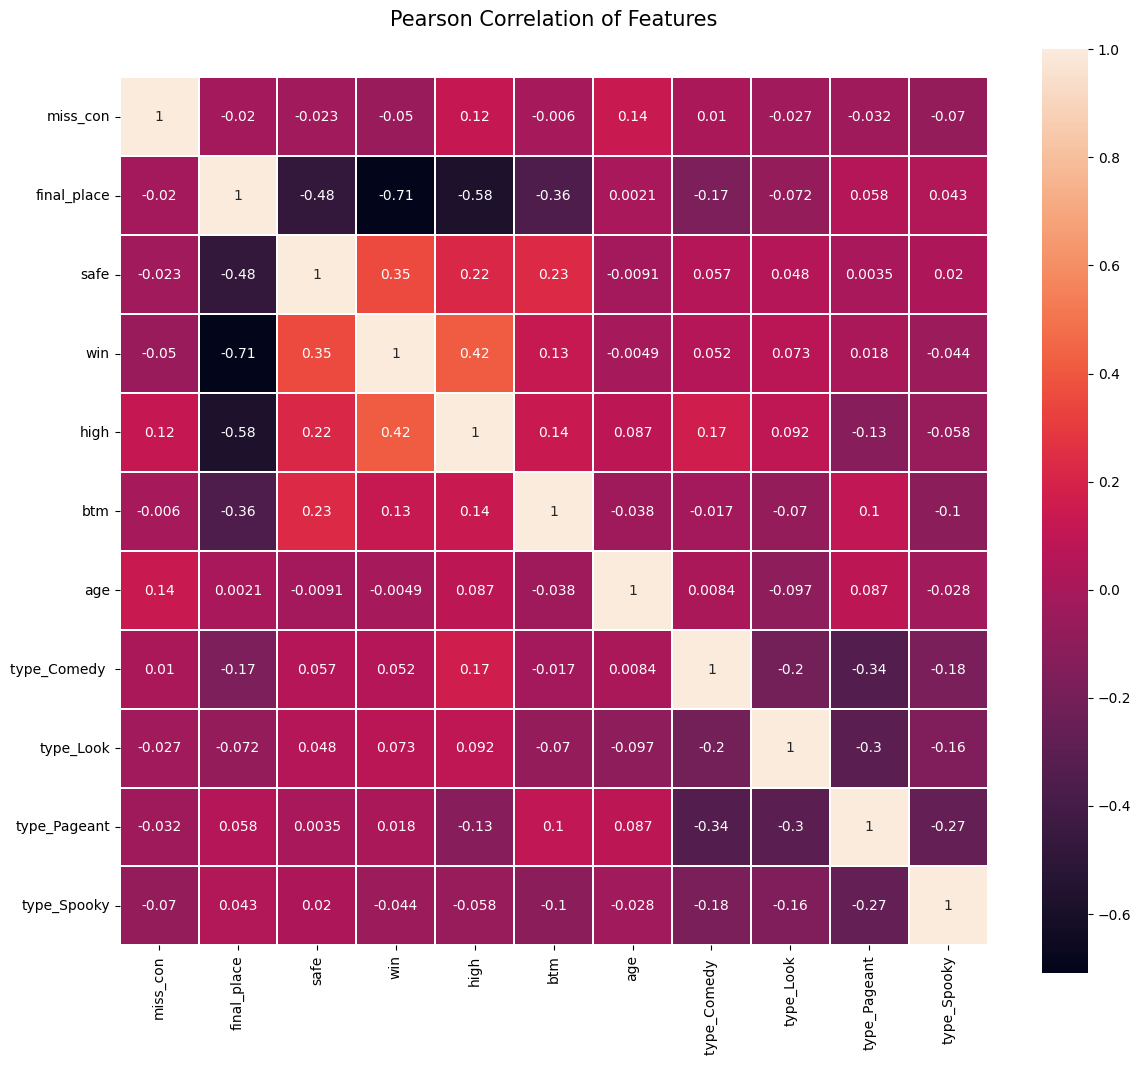

In [15]:
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(queens.corr(),linewidths=0.1,vmax=1.0, 
            square=True, linecolor='white', annot=True)
plt.show()

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_imputed,y,test_size=0.3,random_state=35)

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import StackingRegressor

model1 = LinearRegression()
model2 = KNeighborsRegressor() 
model3 = RandomForestRegressor(random_state=35)
model4 = DecisionTreeRegressor(random_state=35)
model5 = GradientBoostingRegressor(random_state=35)
model6 = AdaBoostRegressor(random_state=35)


model_pipeline = [model1, model2, model3,model4,model5,model6]
model_names = ['Linear Regression', 'KNN', 'Randon Forest','Decision Tree','Gradient Boosting','Ada Boost']

scores = {}

for model, model_name in zip(model_pipeline, model_names):
    mean_score = np.mean(cross_val_score(model, X_train, y_train, cv=10))
    scores[model_name] = mean_score

score_pd = pd.DataFrame(data=scores.values(),index=scores.keys(),columns=['score'])
score_pd.sort_values(by='score',ascending=False)

,score
Linear Regression,0.643239
Gradient Boosting,0.636258
Ada Boost,0.636078
Randon Forest,0.611248
KNN,0.546700
Decision Tree,0.323115


In [17]:
from sklearn.metrics import r2_score

ada = AdaBoostRegressor(random_state=35)
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)
ada_r2 = r2_score(y_test,y_pred)

lm = LinearRegression()
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)
lm_r2 = r2_score(y_test,y_pred)

gb = GradientBoostingRegressor(random_state=35)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
gb_r2 = r2_score(y_test,y_pred)

clf = RandomForestRegressor(random_state=35)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
clf_r2 = r2_score(y_test,y_pred)

r2_score_list = [ada_r2,lm_r2,gb_r2,clf_r2]
model_names = ['Ada Boost','Linear Regression', 'Gradient Boosting','Randon Forest']

scores = {}

for score, model_name in zip(r2_score_list, model_names):
    scores[model_name] = score

r2_score = pd.DataFrame(data=scores.values(),index=scores.keys(),columns=['R2_score'])
r2_score.sort_values(by='R2_score',ascending=False)

,R2_score
Ada Boost,0.710250
Gradient Boosting,0.700220
Linear Regression,0.698574
Randon Forest,0.651296


In [38]:
coef_np = list(lm.coef_)
coef = pd.DataFrame(coef_np,index=X_test.columns).reset_index()
coef.columns = ['variable_name','coefficient']
int_list = []
int_list.append(lm.intercept_)
intercept_lm = pd.DataFrame(data=int_list).reset_index()
intercept_lm.columns = ['variable_name','coefficient']
intercept_lm['variable_name'] = intercept_lm['variable_name'].replace({0:'intercept'})

coef = pd.concat([coef,intercept_lm],axis=0)
coef

,variable_name,coefficient
0,miss_con,0.269296
1,safe,-2.474167
2,win,-8.742373
3,high,-3.995379
4,btm,-3.738740
5,age,-0.120181
6,type_Comedy,-1.323055
7,type_Look,-0.615701
8,type_Pageant,-0.031207
9,type_Spooky,-0.732122


In [40]:
def get_models():
    models = dict()
    models['lm'] = LinearRegression()
    models['rf'] = RandomForestRegressor(random_state=35)
    models['gra'] = GradientBoostingRegressor(random_state=35)
    models['ada'] = AdaBoostRegressor(random_state=35)
    return models

models_dict = get_models()
models = list(models_dict.items())
models

[('lm', LinearRegression()),
 ('rf', RandomForestRegressor(random_state=35)),
 ('gra', GradientBoostingRegressor(random_state=35)),
 ('ada', AdaBoostRegressor(random_state=35))]

In [41]:
model = StackingRegressor(estimators=models, final_estimator=AdaBoostRegressor(random_state=35), cv=10)
model.fit(X_train, y_train).score(X_test, y_test)
ada_mse = round(np.mean((model.predict(X_test)-y_test)**2),2)
ada_var = model.score(X_test,y_test)
print(ada_mse,ada_var)

4.59 0.67562830015902


In [42]:
model = StackingRegressor(estimators=models, final_estimator=AdaBoostRegressor(random_state=35), cv=10)
model.fit(X_train, y_train).score(X_test, y_test)
ada_mse = round(np.mean((model.predict(X_test)-y_test)**2),2)
ada_var = round(model.score(X_test,y_test),2)

model = StackingRegressor(estimators=models, final_estimator=GradientBoostingRegressor(random_state=35), cv=10)
model.fit(X_train, y_train).score(X_test, y_test)
gb_mse = round(np.mean((model.predict(X_test)-y_test)**2),2)
gb_var = round(model.score(X_test,y_test),2)

model = StackingRegressor(estimators=models, final_estimator=RandomForestRegressor(random_state=35), cv=10)
model.fit(X_train, y_train).score(X_test, y_test)
rf_mse = round(np.mean((model.predict(X_test)-y_test)**2),2)
rf_var = round(model.score(X_test,y_test),2)

model = StackingRegressor(estimators=models, final_estimator=LinearRegression(), cv=10)
model.fit(X_train, y_train).score(X_test, y_test)
lm_mse = round(np.mean((model.predict(X_test)-y_test)**2),2)
lm_var = round(model.score(X_test,y_test),2)


mse_list = [ada_mse,gb_mse,rf_mse,lm_mse]
var_list = [ada_var,gb_var,rf_var,lm_var]
model_names = ['Ada Boost stack', 'Gradient Boosting stack','Randon Forest stack','Linear Regression stack']

score_dict = {'model_name':model_names,'mean square error':mse_list,'variance score':var_list}


stack_score = pd.DataFrame.from_dict(score_dict)
stack_score.sort_values(by=['mean square error','variance score'],ascending=False)

,model_name,mean square error,variance score
0,Ada Boost stack,4.59,0.68
1,Gradient Boosting stack,4.14,0.71
2,Randon Forest stack,4.01,0.72
3,Linear Regression stack,3.68,0.74
